# Notebook 6

## Digital health and computational epidemiology
Author: Michele Tizzoni

---

# Digital flu surveillance 

In [173]:
import pandas as pd
import numpy as np
import glob
import seaborn as sns

import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime

from scipy.stats import shapiro, zscore, norm

import matplotlib.mlab as mlab
from sklearn.model_selection import GroupKFold

In [96]:
from matplotlib.dates import DateFormatter

In [57]:
%matplotlib inline

## Data pre-processing

Let's start loading the two datasets:  

* *influnet.csv* contains data on flu incidence gathered by influnet and manually joined into a single file

* *wiki.csv* contains the number of daily visits of some Wikipedia pages aggregated by wikishark ([link](
http://www.wikishark.com/))
Wikipedia pages have been chosen as the relevant ones to provide a proxy signal for the flu season.


In [59]:
dfi = pd.read_csv("./../datasets/influnet.csv", index_col=0)

dfw = pd.read_csv("./../datasets/wiki.csv")

In [60]:
dfw.head()

,Influenza,Influenza aviaria,Influenza suina,Influenza spagnola,Febbre,Temperatura corporea,Termometro,Raffreddore,Rinorrea,Emicrania,...,Acido ascorbico,Antibiotico,Beclometasone,Ibuprofene,Oseltamivir,Vasocostrittore,Mialgia,Cefalea,Pagina principale,Unnamed: 26
01/01/2008,80,108,0,44,199,36,52,50,6,39,...,61,93,0,13,13,8,82,109,497986,NaN
01/02/2008,131,122,0,65,359,56,148,118,10,101,...,113,230,0,20,15,8,125,168,571450,NaN
01/03/2008,188,92,0,87,383,71,168,108,26,93,...,168,223,0,27,17,20,156,162,619931,NaN
01/04/2008,160,107,0,71,397,67,164,102,15,95,...,196,193,0,24,32,13,105,156,621911,NaN
01/05/2008,127,81,0,65,365,63,136,90,14,81,...,126,190,0,12,21,7,205,172,576184,NaN


In [62]:
dfw.drop('Unnamed: 26', axis=1, inplace=True)

In [63]:
dfw.head()

,Influenza,Influenza aviaria,Influenza suina,Influenza spagnola,Febbre,Temperatura corporea,Termometro,Raffreddore,Rinorrea,Emicrania,...,Acido acetilsalicilico,Acido ascorbico,Antibiotico,Beclometasone,Ibuprofene,Oseltamivir,Vasocostrittore,Mialgia,Cefalea,Pagina principale
01/01/2008,80,108,0,44,199,36,52,50,6,39,...,10,61,93,0,13,13,8,82,109,497986
01/02/2008,131,122,0,65,359,56,148,118,10,101,...,17,113,230,0,20,15,8,125,168,571450
01/03/2008,188,92,0,87,383,71,168,108,26,93,...,15,168,223,0,27,17,20,156,162,619931
01/04/2008,160,107,0,71,397,67,164,102,15,95,...,11,196,193,0,24,32,13,105,156,621911
01/05/2008,127,81,0,65,365,63,136,90,14,81,...,12,126,190,0,12,21,7,205,172,576184


Influnet datas are given weekly, so to compare the two datasets we have to aggregate our wikishark data by week.  
Furthermore we have to uniform indices of datasets, in the format *yyyy-ww*, where *yyyy* is the year (4 digits) and *ww* is the week of the year (2 digits)

In [69]:
# extract year and week-of-the-year from datetime in wiki dataset

year=[]
week=[]
for i in range(len(dfw)):
    year.append((pd.to_datetime(dfw.index.values[i])).isocalendar()[0])
    week.append((pd.to_datetime(dfw.index.values[i])).isocalendar()[1])

In [67]:
week[:10]

[1, 1, 1, 1, 1, 1, 2, 2, 2, 2]

In [70]:
for w in range(len(week)):
    if len(str(week[w]))==1:
        week[w]="0"+str(week[w])

In [71]:
week[:10]

['01', '01', '01', '01', '01', '01', '02', '02', '02', '02']

In [72]:
dfw["year"]=year
dfw["week"]=week

In [73]:
dfw.head(10)

,Influenza,Influenza aviaria,Influenza suina,Influenza spagnola,Febbre,Temperatura corporea,Termometro,Raffreddore,Rinorrea,Emicrania,...,Antibiotico,Beclometasone,Ibuprofene,Oseltamivir,Vasocostrittore,Mialgia,Cefalea,Pagina principale,year,week
01/01/2008,80,108,0,44,199,36,52,50,6,39,...,93,0,13,13,8,82,109,497986,2008,01
01/02/2008,131,122,0,65,359,56,148,118,10,101,...,230,0,20,15,8,125,168,571450,2008,01
01/03/2008,188,92,0,87,383,71,168,108,26,93,...,223,0,27,17,20,156,162,619931,2008,01
01/04/2008,160,107,0,71,397,67,164,102,15,95,...,193,0,24,32,13,105,156,621911,2008,01
01/05/2008,127,81,0,65,365,63,136,90,14,81,...,190,0,12,21,7,205,172,576184,2008,01
01/06/2008,130,75,0,59,310,69,177,71,10,88,...,162,0,18,21,5,219,211,586299,2008,01
01/07/2008,173,122,0,137,382,93,212,119,22,141,...,284,0,26,21,24,399,313,657334,2008,02
01/08/2008,137,109,0,84,397,66,218,92,30,122,...,252,0,39,22,17,285,272,648248,2008,02
01/09/2008,162,102,0,84,410,96,200,80,12,117,...,323,0,26,32,11,224,233,649829,2008,02
01/10/2008,125,84,0,84,382,79,178,74,22,123,...,236,0,31,20,9,235,194,641154,2008,02


In [74]:
dfw['yw'] = dfw.year.astype(str).str.cat(dfw.week.astype(str), sep='-')

In [75]:
dfw.head()

,Influenza,Influenza aviaria,Influenza suina,Influenza spagnola,Febbre,Temperatura corporea,Termometro,Raffreddore,Rinorrea,Emicrania,...,Beclometasone,Ibuprofene,Oseltamivir,Vasocostrittore,Mialgia,Cefalea,Pagina principale,year,week,yw
01/01/2008,80,108,0,44,199,36,52,50,6,39,...,0,13,13,8,82,109,497986,2008,01,2008-01
01/02/2008,131,122,0,65,359,56,148,118,10,101,...,0,20,15,8,125,168,571450,2008,01,2008-01
01/03/2008,188,92,0,87,383,71,168,108,26,93,...,0,27,17,20,156,162,619931,2008,01,2008-01
01/04/2008,160,107,0,71,397,67,164,102,15,95,...,0,24,32,13,105,156,621911,2008,01,2008-01
01/05/2008,127,81,0,65,365,63,136,90,14,81,...,0,12,21,7,205,172,576184,2008,01,2008-01


In [76]:
# aggregate data by week (summing)
dfw1 = dfw.groupby(['yw']).sum()

In [77]:
dfw1.head()

,Influenza,Influenza aviaria,Influenza suina,Influenza spagnola,Febbre,Temperatura corporea,Termometro,Raffreddore,Rinorrea,Emicrania,...,Antibiotico,Beclometasone,Ibuprofene,Oseltamivir,Vasocostrittore,Mialgia,Cefalea,Pagina principale,year,week
yw,,,,,,,,,,,,,,,,,,,,,
2008-01,816,585,0,391,2013,362,845,539,81,497,...,1091,0,114,119,61,892,978,3473761,12048,010101010101
2008-02,959,675,0,593,2557,542,1363,550,146,791,...,1730,0,211,146,93,1548,1464,4412040,14056,02020202020202
2008-03,1050,675,0,511,2269,419,1256,540,138,919,...,1636,0,200,116,75,926,1391,4366358,14056,03030303030303
2008-04,1001,555,0,452,2470,447,1168,506,139,830,...,1486,0,256,456,113,769,1156,4446840,14056,04040404040404
2008-05,1064,557,0,491,2347,387,1113,517,117,803,...,1586,1,265,165,114,710,1248,4454156,14056,05050505050505


In [78]:
# remove some garbage columns
dfw1.drop(['year','week'], axis=1, inplace=True)

In [79]:
dfw1

,Influenza,Influenza aviaria,Influenza suina,Influenza spagnola,Febbre,Temperatura corporea,Termometro,Raffreddore,Rinorrea,Emicrania,...,Acido acetilsalicilico,Acido ascorbico,Antibiotico,Beclometasone,Ibuprofene,Oseltamivir,Vasocostrittore,Mialgia,Cefalea,Pagina principale
yw,,,,,,,,,,,,,,,,,,,,,
2008-01,816,585,0,391,2013,362,845,539,81,497,...,78,809,1091,0,114,119,61,892,978,3473761
2008-02,959,675,0,593,2557,542,1363,550,146,791,...,105,1261,1730,0,211,146,93,1548,1464,4412040
2008-03,1050,675,0,511,2269,419,1256,540,138,919,...,98,1251,1636,0,200,116,75,926,1391,4366358
2008-04,1001,555,0,452,2470,447,1168,506,139,830,...,93,1313,1486,0,256,456,113,769,1156,4446840
2008-05,1064,557,0,491,2347,387,1113,517,117,803,...,102,1319,1586,1,265,165,114,710,1248,4454156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-46,673,303,64,583,707,77,957,30,132,656,...,1317,1301,861,195,1079,54,12,220,496,1492868
2016-47,451,171,36,419,492,55,701,19,82,499,...,821,734,554,127,740,39,6,198,349,1007567
2016-48,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Finally we can join the two datasets, and select only the weeks for what we have data from both datasets (basically from flu season 2008-2009 to season 2015-2016).  
For some weeks of the years, there are no incidence data from influnet: so we equal to zero, assuming that in these weeks flu incidence is zero or near to zero.

In [80]:
df1 = pd.concat([dfi, dfw1], axis=1)
df2 = df1.loc['2009-40':'2016-15']
df3 = df2.fillna(value=0)

In [81]:
df3.head()

,incidenza_tot,Influenza,Influenza aviaria,Influenza suina,Influenza spagnola,Febbre,Temperatura corporea,Termometro,Raffreddore,Rinorrea,...,Acido acetilsalicilico,Acido ascorbico,Antibiotico,Beclometasone,Ibuprofene,Oseltamivir,Vasocostrittore,Mialgia,Cefalea,Pagina principale
2009-40,1.05,1065.0,645.0,6925.0,694.0,2009.0,508.0,909.0,910.0,180.0,...,129.0,1006.0,1049.0,29.0,712.0,843.0,96.0,329.0,852.0,2977187.0
2009-41,1.48,1781.0,1111.0,10010.0,1273.0,3611.0,734.0,1435.0,1740.0,344.0,...,224.0,1834.0,2047.0,43.0,1289.0,1009.0,228.0,681.0,1445.0,5322952.0
2009-42,1.76,1613.0,714.0,8366.0,992.0,3202.0,778.0,1684.0,1546.0,307.0,...,229.0,1802.0,1459.0,46.0,1068.0,821.0,149.0,519.0,1182.0,4353503.0
2009-43,4.49,2456.0,855.0,11858.0,1361.0,5353.0,1155.0,2408.0,1827.0,403.0,...,325.0,2032.0,1918.0,53.0,1288.0,1260.0,234.0,639.0,1289.0,5233626.0
2009-44,9.31,4399.0,1449.0,30763.0,2661.0,6234.0,1298.0,2140.0,1476.0,541.0,...,402.0,2528.0,2116.0,80.0,1680.0,3235.0,238.0,1011.0,1543.0,5132345.0


#  1

Let's start our analisys between real data and Wikipedia pageview, using only "*Influenza*" page: we extract the two series, normalize them, plot and calculate correlation.

Corr =  0.664508580832


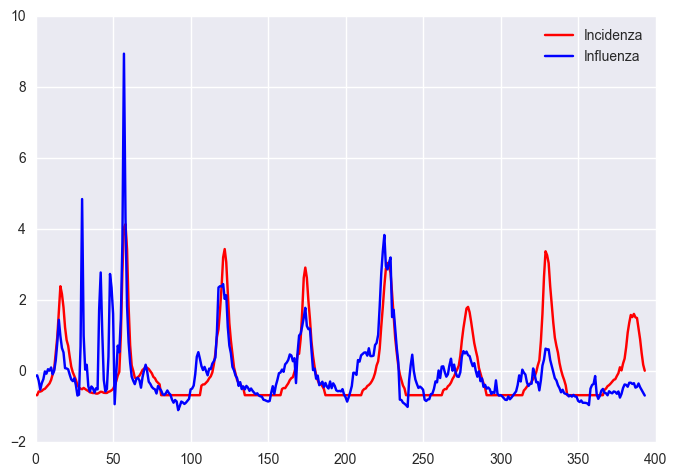

In [7]:
a = np.array(df3["incidenza_tot"])
b = np.array(df3["Influenza"])
a = zscore(a)
b = zscore(b)
print("Corr = ", np.corrcoef(a,b)[0,1])

plt.plot(a, 'r-', label='Flu incidence')
plt.plot(b, 'b-', label='Wiki pageviews')
plt.legend()
plt.show()

In [88]:
a = zscore(df3["incidenza_tot"])
b = zscore(df3["Influenza"])

print("Corr = ", np.corrcoef(a,b)[0,1])


Corr =  0.7027295317309643


In [127]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.dates as mdates

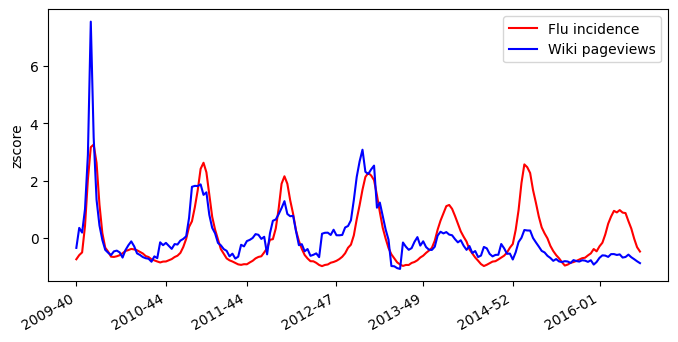

In [140]:
fig, ax = plt.subplots(figsize=(8,4))
plt.plot(a, 'r-', label='Flu incidence')
plt.plot(b, 'b-', label='Wiki pageviews')
plt.ylabel('zscore')


plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

fig.autofmt_xdate()
plt.legend()

From plot we see that there is an overall similar trend between the visits on "Influenza" wikipage and real data on flu. 

# 2 

Now it's time to add more Wikipedia pages to our analysis. 
We got a list of about 20 Wikipedia pages, including symptoms, medicines, vaccines and some "famous" seasonal flu.  
  
Note that the Influnet data are referred to Italy as a country, while for wikipedia we can only choose the language (Italian) but there is no availability for geolocalized data. 
Anyway, about 61.7 million people in the World speak Italian, and 55 of them (90%) live in Italy ([source](https://it.wikipedia.org/wiki/Lingua_italiana#Diffusione_nei_paesi_in_cui_non_.C3.A8_lingua_ufficiale)). 

In [141]:
print(len(df3.columns))
print(df3.columns.values.tolist())

27
['incidenza_tot', 'Influenza', 'Influenza aviaria', 'Influenza suina', 'Influenza spagnola', 'Febbre', 'Temperatura corporea', 'Termometro', 'Raffreddore', 'Rinorrea', 'Emicrania', 'Tosse', 'Nausea', 'Vomito', 'Vaccino', 'Vaccino antinfluenzale', 'Paracetamolo', 'Acido acetilsalicilico', 'Acido ascorbico', 'Antibiotico', 'Beclometasone', 'Ibuprofene', 'Oseltamivir', 'Vasocostrittore', 'Mialgia', 'Cefalea', 'Pagina principale']


Let's compute correlation between *flu incidence* and the visits to each of these wiki pages.  
*Influenza* has the highest correlation, followed by some symptoms (*Febbre*, *Rinorrea*, *Tosse*) and some medicals (*Paracetamolo*, *Antibiotico*, * Ibuprofene*).

In [142]:
corr = df3.corr(method='pearson')
print(corr[corr.columns[0]])

incidenza_tot             1.000000
Influenza                 0.702730
Influenza aviaria         0.406529
Influenza suina           0.401089
Influenza spagnola        0.404709
Febbre                    0.499748
Temperatura corporea      0.453027
Termometro                0.193601
Raffreddore               0.123577
Rinorrea                  0.436015
Emicrania                 0.092660
Tosse                     0.322765
Nausea                    0.076384
Vomito                    0.110733
Vaccino                   0.395848
Vaccino antinfluenzale   -0.235749
Paracetamolo              0.452843
Acido acetilsalicilico    0.110464
Acido ascorbico           0.378496
Antibiotico               0.444858
Beclometasone             0.233893
Ibuprofene                0.329697
Oseltamivir               0.430697
Vasocostrittore           0.225476
Mialgia                   0.409173
Cefalea                   0.105641
Pagina principale         0.067736
Name: incidenza_tot, dtype: float64


It's also interesting notice correlations between all our pages: as we can see there are some "blocks"of words that are highly correlated with each others; the biggest one contains symptoms and medicines, while there is another one for some particular flu.

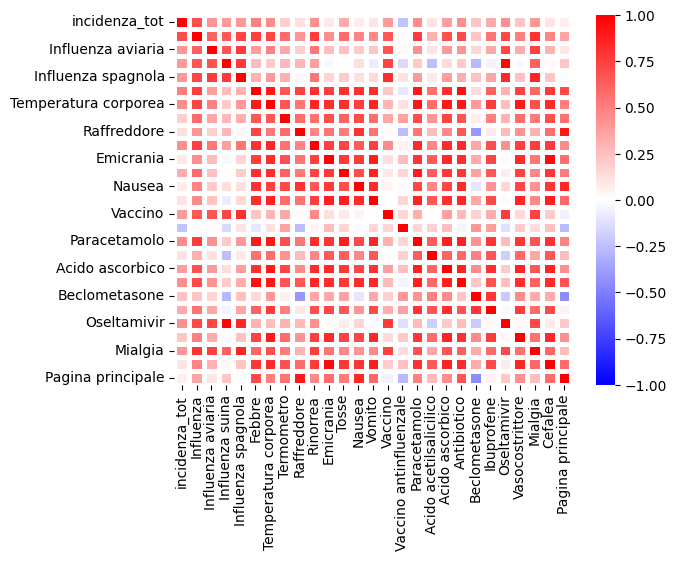

In [143]:
sns.heatmap(corr, cmap='bwr', vmax=1.0, vmin=-1.0 , linewidths=2.5)
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.show()

<center><h1>PART 3</h1></center>

Now we'll build (and refine) a multivariate linear regression model, using the package [StatsModels](http://statsmodels.sourceforge.net/devel/index.html) and in particular its function [OLS](http://statsmodels.sourceforge.net/devel/generated/statsmodels.regression.linear_model.OLS.html#statsmodels.regression.linear_model.OLS) (a simple ordinary least squares model).   
We put the regression and some preliminar operation (including standardization and separation of x and y) into a single function:

In [159]:
def mreg(df):
    y = df[df.columns[0]]
    x = np.array(df[df.columns[1:]])
    xst = zscore(x)
    xst = sm.add_constant(xst)
    out = sm.OLS(endog=y, exog=xst).fit()
    
    return out

#### Original dataset
Let's start simply using our original dataset.

$R^2$ is the coefficient of determination between data estimated by our model and real data. 

In [160]:
r3=mreg(df3)
print(r3.summary())

                            OLS Regression Results                            
Dep. Variable:          incidenza_tot   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     35.79
Date:                Sun, 21 May 2023   Prob (F-statistic):           1.75e-55
Time:                        21:54:49   Log-Likelihood:                -307.85
No. Observations:                 196   AIC:                             669.7
Df Residuals:                     169   BIC:                             758.2
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2496      0.090     36.297      0.0

#### Normalized dataset  
Observing that the global visits on Wikipedia site (we considered the [homepage](https://it.wikipedia.org/wiki/Pagina_principale) as indicator) has some trends ([see here](http://www.wikishark.com/title/it/Pagina_principale?text_search=&gtype=0&factors=&view=1)), we can think that the number of visits to a specific page is somehow connected to the total visits.  
So let's try to appy regression model to the dataset normalized by total wikipedia visits: $R^2=0.809$ slightly increases.

In [165]:
home = (df3['Pagina principale'])           # vector of global wikipedia visits

df4 = df3.div(home, axis=0)                 # normalize each page's visits dividing by total 

df4["incidenza_tot"] = df3["incidenza_tot"] # except for incidenza_tot

df4.drop('Pagina principale', axis=1, inplace=True)

r2 = mreg(df4)

print("R2 =", r2.rsquared)


R2 = 0.8857713599427505


#### Plot
Let's plot together real datas and predicted ones

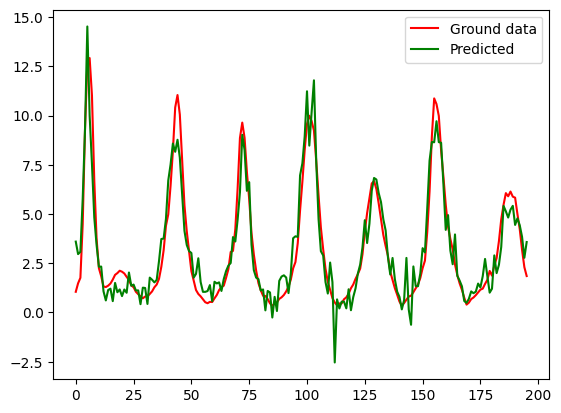

In [167]:
real = np.array(df3["incidenza_tot"])
pred = np.array(r2.fittedvalues)

plt.plot(real, 'r-', label='Ground data')
plt.plot(pred, 'g-', label='Predicted')
plt.legend()
plt.show()

#### Errors
Now let's check the residuals of our model. If the model is correct, residuals or errors should distribute like a Normal with mean = 0.  
In fact, mean of errors is equal to zero, and the result of Shapiro-Wilk's test is very near to 1, which means that residuals are normally distribuited.

Errors' mean: -1.0785023667787234e-15 
Errors' std : 1.0033009085176596
Shapiro-Wilk's test:  0.9789038896560669


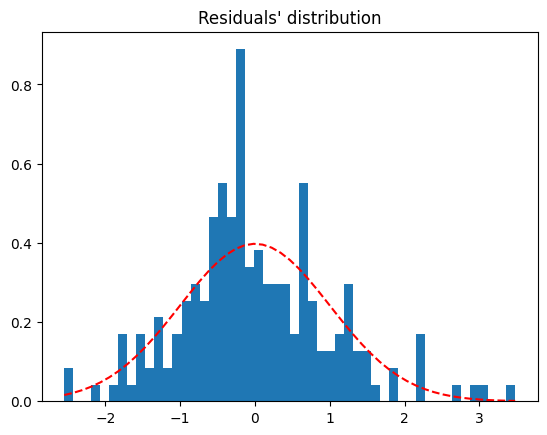

In [176]:
res=r2.resid
mu=np.mean(res)
sigma=np.std(res)
print("Errors' mean:", mu, "\nErrors' std :", sigma)
swtest=shapiro(res)
print("Shapiro-Wilk's test: ", swtest[0])

num_bins = 50
n, bins, patches = plt.hist(res, num_bins,density=True)
y = norm.pdf(bins, mu, sigma)     
plt.plot(bins, y, 'r--')
plt.title('Residuals\' distribution')
plt.show()

#### Cross-Validation
Evaluate our model via [leave-one-group-out](http://scikit-learn.org/0.18/modules/cross_validation.html#leave-one-group-out) Cross Validation. Basically for each season we create a model with other seasons as train set and the given season as test set. Then we measure, through $R^2$, how good the prediction is.



In [220]:
# first we create a vector to assign each week to its corresponding season
season=[["2009-10"]*(len(df4.loc["2009-40":"2010-39"])),
        ["2010-11"]*(len(df4.loc["2010-40":"2011-39"])), 
        ["2011-12"]*(len(df4.loc["2011-40":"2012-39"])),
        ["2012-13"]*(len(df4.loc["2012-40":"2013-39"])), 
        ["2013-14"]*(len(df4.loc["2013-40":"2014-39"])),
        ["2014-15"]*(len(df4.loc["2014-40":"2015-39"])), 
        ["2015-16"]*(len(df4.loc["2015-40":]))]
# add vector to dataset (and convert to list from list of list)
df4["season"]=sum(season, [])

In [221]:
# y, as usual, is our ground data set
# x is the array composed by wikipedia pages
ycv = df4[df4.columns[0]]
xcv = np.array(df4[df4.columns[1:-2]])

Season = 2009-10  -  R2 = -2.1545444165745113
Season = 2010-11  -  R2 = 0.6880098911161516
Season = 2011-12  -  R2 = 0.47077660565110546
Season = 2012-13  -  R2 = 0.08192650711034599
Season = 2013-14  -  R2 = 0.7599158918127629
Season = 2014-15  -  R2 = 0.8548963025941612
Season = 2015-16  -  R2 = -1.7173576181735668
average R-squared = -0.14519669092336443


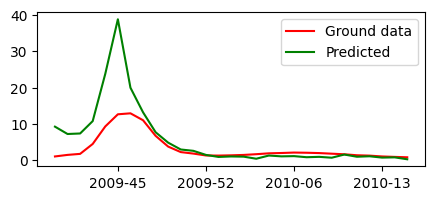

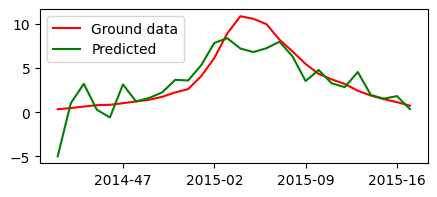

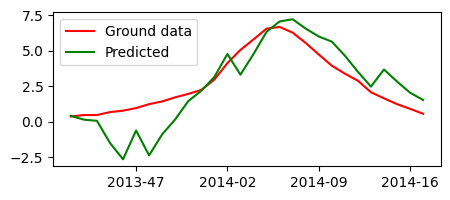

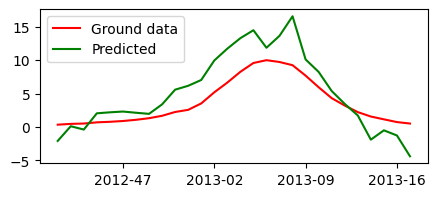

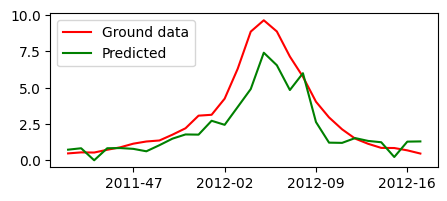

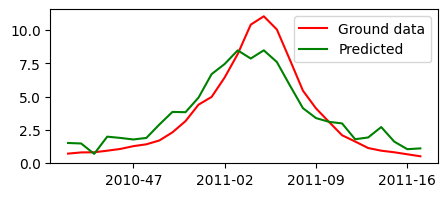

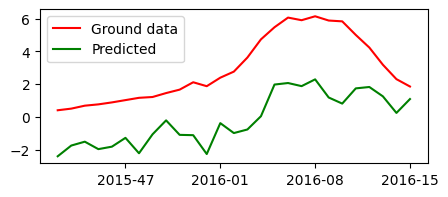

In [222]:
# for each group (season) we compute the R^2 between ground data and values predicted by the model using the rest of the data
# and plot predicted and ground data
r2vec=[]

titles=["2009-10","2010-11","2011-12","2012-13","2013-14","2014-15","2015-16"]

i=0

for train, test in GroupKFold(n_splits=7).split(xcv, ycv, groups=df4["season"]):

    y  = ycv[train]
    x  = sm.add_constant(np.array(xcv[train]))
    
    results = sm.OLS(endog=y, exog=x).fit()
    
    xt = sm.add_constant(np.array(xcv[test])) 
    yp = results.predict(xt)
    
    #corr = np.corrcoef(yp, ycv[test])[0,1]
    
    r2 = 1 - (((ycv[test] - yp) ** 2).sum() / ((ycv[test] - np.mean(ycv[test])) ** 2).sum())
    
    r2vec.append(r2)
    
    print("Season =", titles[i], " -  R2 =", r2)
    
    plt.figure(figsize=(5,2))
    plt.plot(ycv[test], 'r-', label='Ground data')
    plt.plot(yp, 'g-', label='Predicted')
    plt.legend()
    plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())

    
    i=i+1

print("average R-squared =", np.mean(r2vec) )


#### Autoregressive model
Like time series, flu incidence has consecutive (or close) values strictly correlated between each others. It also has a year-based seasonality (ie: incidence of a given week is somehow correlated to the incidence of the same week of the previous year); but flu spread (start, peak, end) differs by some weeks every year.   
So we add in our model the Influnet incidence for the week preceding the target week and the pageview counts for all the pages  selected for the week preceding the target week. 

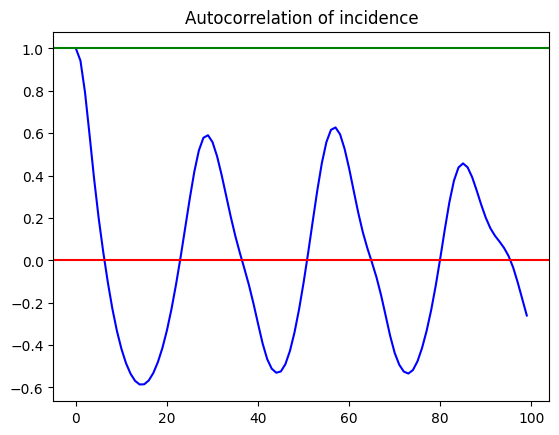

In [194]:
inc = pd.Series(df4["incidenza_tot"])
ac = [inc.autocorr(lag=i) for i in range(100)]
plt.plot(ac, color="blue")
plt.title("Autocorrelation of incidence")
plt.axhline(0, color="red")
plt.axhline(1, color="green")
plt.show()

In [195]:
df5=df4
df5.drop("season", axis=1, inplace=True)

In [210]:
# add ground data of previous week
df5["Prev_Inc"] = df5["incidenza_tot"].shift(1)

# remove first column (which contains some NaNs)
df6 = df5.loc["2009-41":"2016-15"]

In [211]:
df6

,incidenza_tot,Influenza,Influenza aviaria,Influenza suina,Influenza spagnola,Febbre,Temperatura corporea,Termometro,Raffreddore,Rinorrea,...,Acido acetilsalicilico,Acido ascorbico,Antibiotico,Beclometasone,Ibuprofene,Oseltamivir,Vasocostrittore,Mialgia,Cefalea,Prev_Inc
2009-41,1.48,0.000335,0.000209,0.001881,0.000239,0.000678,0.000138,0.000270,0.000327,0.000065,...,0.000042,0.000345,0.000385,0.000008,0.000242,0.000190,0.000043,0.000128,0.000271,1.05
2009-42,1.76,0.000371,0.000164,0.001922,0.000228,0.000735,0.000179,0.000387,0.000355,0.000071,...,0.000053,0.000414,0.000335,0.000011,0.000245,0.000189,0.000034,0.000119,0.000272,1.48
2009-43,4.49,0.000469,0.000163,0.002266,0.000260,0.001023,0.000221,0.000460,0.000349,0.000077,...,0.000062,0.000388,0.000366,0.000010,0.000246,0.000241,0.000045,0.000122,0.000246,1.76
2009-44,9.31,0.000857,0.000282,0.005994,0.000518,0.001215,0.000253,0.000417,0.000288,0.000105,...,0.000078,0.000493,0.000412,0.000016,0.000327,0.000630,0.000046,0.000197,0.000301,4.49
2009-45,12.65,0.001680,0.000709,0.008984,0.001642,0.001429,0.000360,0.000518,0.000317,0.000150,...,0.000095,0.000685,0.000541,0.000019,0.000377,0.001503,0.000040,0.000789,0.000338,9.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-11,5.00,0.000651,0.000202,0.000175,0.000754,0.001031,0.000063,0.000413,0.000055,0.000149,...,0.001225,0.001101,0.000842,0.000191,0.001061,0.000071,0.000024,0.000325,0.000603,5.83
2016-12,4.23,0.000592,0.000156,0.000199,0.000616,0.000900,0.000073,0.000334,0.000037,0.000170,...,0.000990,0.000902,0.000730,0.000176,0.000967,0.000064,0.000024,0.000305,0.000564,5.00
2016-13,3.18,0.000545,0.000235,0.000097,0.000625,0.000891,0.000085,0.000352,0.000026,0.000168,...,0.001063,0.001009,0.000849,0.000192,0.001030,0.000054,0.000016,0.000358,0.000574,4.23
2016-14,2.30,0.000447,0.000194,0.000085,0.000545,0.000756,0.000077,0.000389,0.000024,0.000150,...,0.000986,0.001028,0.000743,0.000192,0.000960,0.000059,0.000024,0.000308,0.000569,3.18


In [200]:
r7=mreg(df6)
print(r7.rsquared)

0.9629409110934464


Simply adding previous week's incidence boost our $R^2 = 0.948$ !  
But let's try to add also previous week's pagevisits:

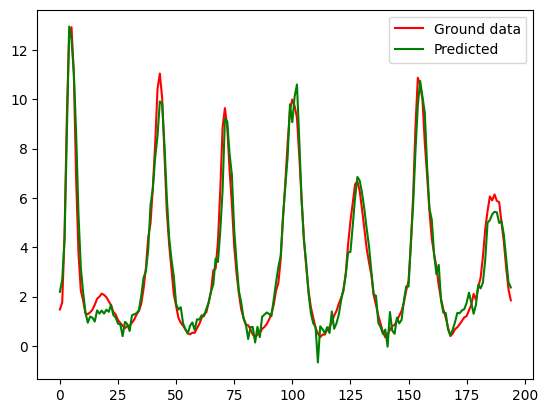

In [204]:
real2 = np.array(df6["incidenza_tot"])
pred2 = np.array(r7.fittedvalues)

plt.plot(real2, 'r-', label='Ground data')
plt.plot(pred2, 'g-', label='Predicted')
plt.legend()
plt.show()

#### Predictions
Finally, it's time to use our model to predict incidence.  
So we use data until the year 2014 (containing pageview of the given week and of the previous and influnet incidence of the previous week) to train our model.  
Then we use the model to predict incidence for weeks of the years 2015 and 2016 (only first weeks) having pageview data in realtime and from the previous week and influnet data only from the previous week.

In [212]:
df7 = df6.loc["2009-41":"2014-53"]

df8 = df6.loc["2015-01":]

In [213]:
r7=mreg(df7)
#print("R2 =", r9.rsquared)
print(r7.summary())

                            OLS Regression Results                            
Dep. Variable:          incidenza_tot   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     144.4
Date:                Sun, 21 May 2023   Prob (F-statistic):           2.90e-80
Time:                        22:48:03   Log-Likelihood:                -119.73
No. Observations:                 151   AIC:                             293.5
Df Residuals:                     124   BIC:                             374.9
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0903      0.048     64.355      0.0

In [216]:
# split and preprocess our datas
ytr = df7[df7.columns[0]]
xtr = np.array(df7[df7.columns[1:]])

yte = df8[df8.columns[0]]
xte = np.array(df8[df8.columns[1:]])

xtr = sm.add_constant(xtr)
xte = sm.add_constant(xte)

# fit the model
results = sm.OLS(endog=ytr, exog=xtr).fit()

# predict for 2015-2016
ypre = results.predict(xte)

# calculate R^2
corr = (np.corrcoef(ypre,yte)[0,1])**2
print("R^2 =",corr)

R^2 = 0.8516976099138406


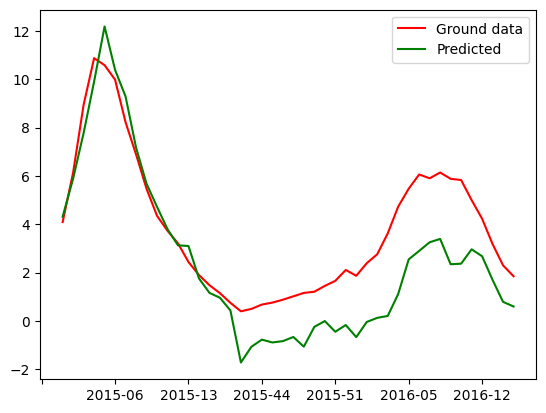

In [218]:
plt.plot(yte, "r-", label="Ground data")
plt.plot(ypre, "g-", label="Predicted")
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())

plt.legend()
plt.show()